In [ ]:
!pip install skforecast

!pip install pmdarima

In [ ]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.feature_selection import RFE     #Recursive Feature
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
import numpy as np
from datetime import timedelta
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from numpy import log

# pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import preprocessing as ppc
from pmdarima import pipeline

#from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax, grid_search_sarimax


from sklearn.metrics import mean_squared_error

#import cx_Oracle
#from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import plotly.express as px

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab_Notebooks/Cenace/DatasetsCENACE/DatosFSUE.xlsx')

print(df.shape)

print(df.info())
df.head()



(132, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      132 non-null    int64         
 1   fecha   132 non-null    datetime64[ns]
 2   monto   132 non-null    float64       
 3   tipo    132 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ KB
None


,id,fecha,monto,tipo
0,0,2023-06-30,23927432.47,FSUE
1,1,2023-07-01,21999930.48,FSUE
2,2,2023-07-02,15219248.89,FSUE
3,3,2023-07-03,19145757.36,FSUE
4,4,2023-07-04,20740833.31,FSUE


# EDA

## Analisis de valores nulos

In [ ]:
nulos = df.isnull().sum()
conteo_total = df.isnull().count()

total = nulos
percent = total / conteo_total

print(total, percent)

df_null = pd.concat([total, percent], axis = 1, keys = ['total', 'percent']).T


df_null

id       0
fecha    0
monto    0
tipo     0
dtype: int64 id       0.0
fecha    0.0
monto    0.0
tipo     0.0
dtype: float64


,id,fecha,monto,tipo
total,0.0,0.0,0.0,0.0
percent,0.0,0.0,0.0,0.0


## Analisis de valores duplicados

In [ ]:
conteo_duplicados = df.groupby(['fecha']).count()
conteo_duplicados
conteo_duplicados.loc[conteo_duplicados['tipo'] > 1]



,id,monto,tipo
fecha,,,
2023-09-23,2,2,2


In [ ]:
df = df.drop([86])

In [ ]:
#df.drop_duplicates()

conteo_duplicados = df.groupby(['fecha']).count()
conteo_duplicados
conteo_duplicados.loc[conteo_duplicados['tipo'] > 1]


,id,monto,tipo
fecha,,,


In [ ]:
df.loc[df['fecha'] == '2023-09-23']




,id,fecha,monto,tipo
85,85,2023-09-23,29243051.85,FSUE


In [ ]:
#df.asfreq(freq='D')

df.set_index(df['fecha'], inplace = True)
df = df[['fecha', 'monto']]

df.head()

,fecha,monto
fecha,,
2023-06-30,2023-06-30,23927432.47
2023-07-01,2023-07-01,21999930.48
2023-07-02,2023-07-02,15219248.89
2023-07-03,2023-07-03,19145757.36
2023-07-04,2023-07-04,20740833.31


# Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=3414.415, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=3436.217, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=3413.927, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=3418.329, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3698.364, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=3418.791, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=3415.344, Time=2.13 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=3414.082, Time=0.30 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=3412.403, Time=0.15 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=3408.036, Time=0.29 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=3409.707, Time=2.40 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=3432.269, Time=0.26 sec
 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=3409.843, Time=0.42 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=3409.802, Time=0.36 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept

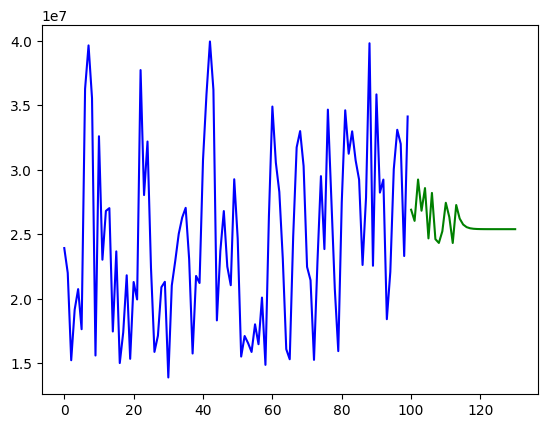

In [ ]:
fsue = df['monto']

trainSize = 100

# Separación de datos en entrenamiento y pruebas
y_train, y_test = train_test_split(fsue, train_size = trainSize)

# The Triunvirate build(), fit(), predict()

# build and fit
#model = pm.auto_arima(y_train, stationary=False, information_criterion='aic', scoring='mse', D=1, d=1, trend='c', max_Q = 8, max_P=8, start_p=2, start_q=2 )
model = pm.auto_arima(y_train,scoring='mse', m=7, stationary=False, seasonal=True, trace=True)

print(model.summary())

#predict
forecasts = model.predict(y_test.shape[0])

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(fsue.shape[0])
plt.plot(x[:trainSize], y_train, c='blue')
plt.plot(x[trainSize:], forecasts, c='green')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3430.526, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3698.364, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3451.490, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3639.020, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3431.457, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3430.352, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3442.721, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3446.251, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3432.344, Time=0.43 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3447.522, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3422.699, Time=0.55 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3420.852, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3422.921, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : 

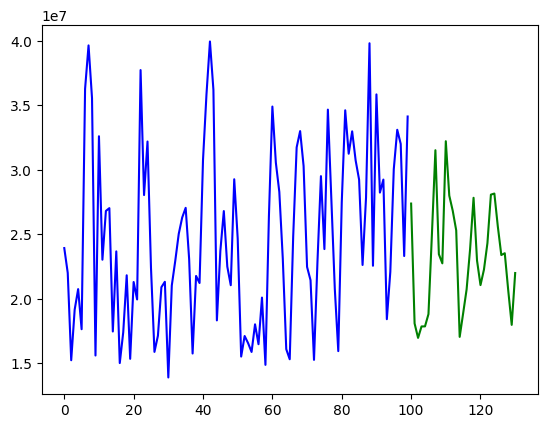

In [ ]:
y_train, y_test = train_test_split(fsue, train_size=trainSize)

pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=50, k=20)), #mejor opcion m=50, k=20, otras opciones m=20, k=10  m=30 k=15
    ("arima", pm.auto_arima(y_train, stepwise=True, trace=1, stationary= False,
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

y_train = list(y_train)

pipe.fit(y_train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=31, return_conf_int=True)
print("\nForecasts:")
print(preds)



# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(fsue.shape[0])
plt.plot(x[:trainSize], y_train, c='blue')
plt.plot(x[trainSize:], preds, c='green')
plt.show()

# Metodología Box Jenkins

In [ ]:
#df.to_excel('D:/A2161.CENACE/Downloads/DatosFSUE.xlsx')

# 1. Identificación

In [ ]:
fig = px.line(df, x='fecha', y='monto', title='Comportamiento histórico del FSUE')

fig.show()

In [ ]:
# Eliminación de Outlier
# df_query = df.loc[df['monto'] > 40000000]
# median = df['monto'].median()
# print(median)

# df_query
# df.loc[df['monto'] > 40000000, 'monto'] = median
# df.loc[90, 'monto']

In [ ]:
df.iloc[90][1]

35859570.23

In [ ]:
fig = px.line(df, x='fecha', y='monto', title='Comportamiento histórico del FSUE')
fig.show()

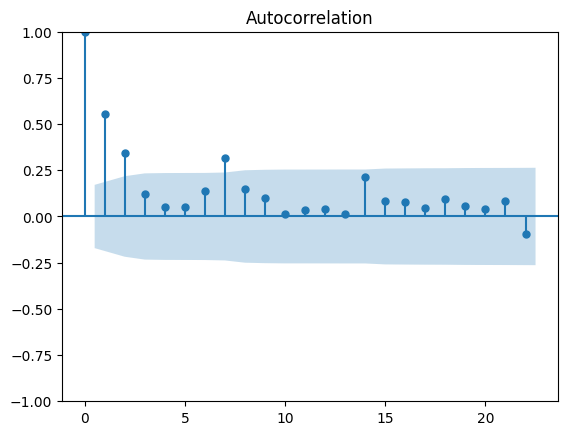

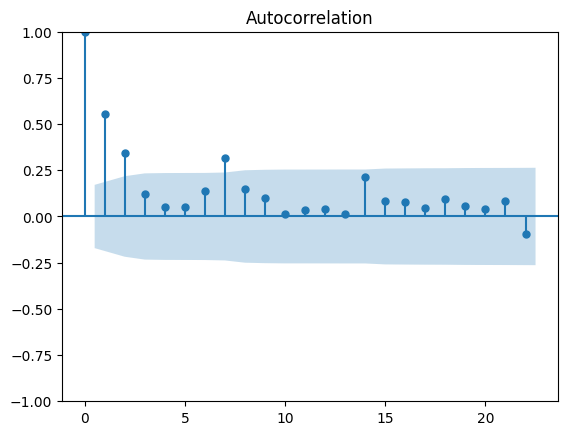

In [ ]:
fsue = df['monto']

plot_acf(fsue)

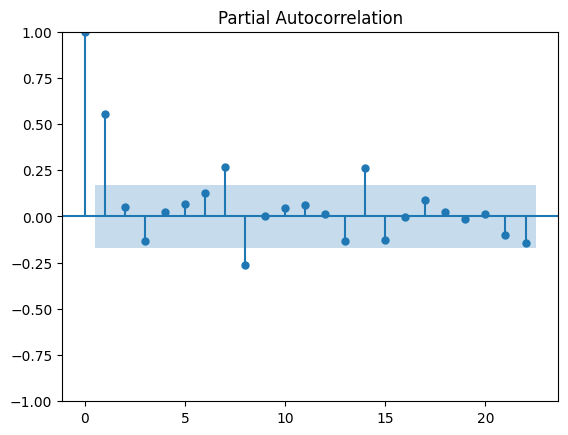

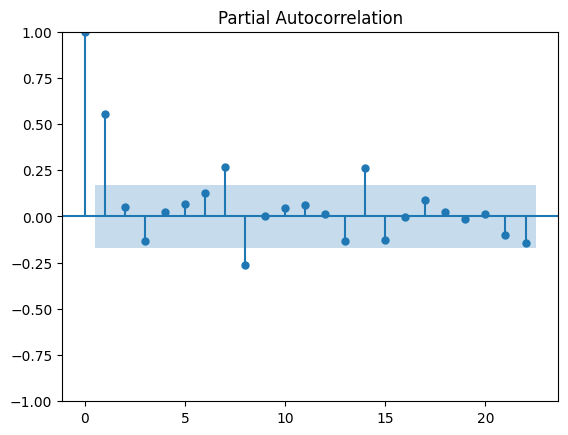

In [ ]:
plot_pacf(fsue)

In [ ]:
adf_res = adfuller(fsue)
adf_diff1 = adfuller(fsue.diff().dropna())
adf_diff2 = adfuller(fsue.diff().diff().dropna())

print('ADF original series p-value: ', adf_res[1])
print('ADF 1st diff p-value:', adf_diff1[1])
print('ADF 2nd diff p-value:', adf_diff2[1])

ADF original series p-value:  0.7783267715630466
ADF 1st diff p-value: 0.0011086314301902709
ADF 2nd diff p-value: 4.466730603829376e-09


* Datos no son estacionarios, hay que aplicar primeras diferencias o segundas diferencias
* El autocorrelograma nos indica que debería tener 1 o 2 medias moviles

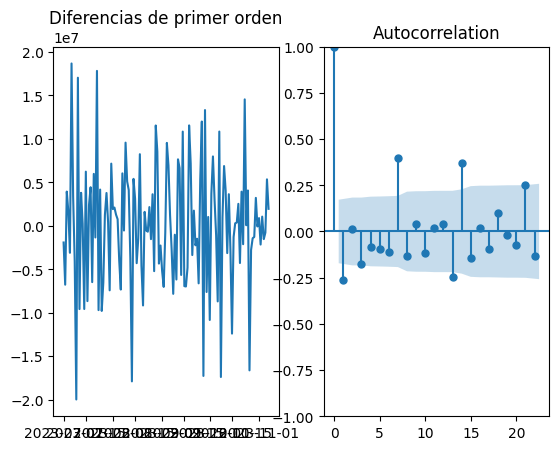

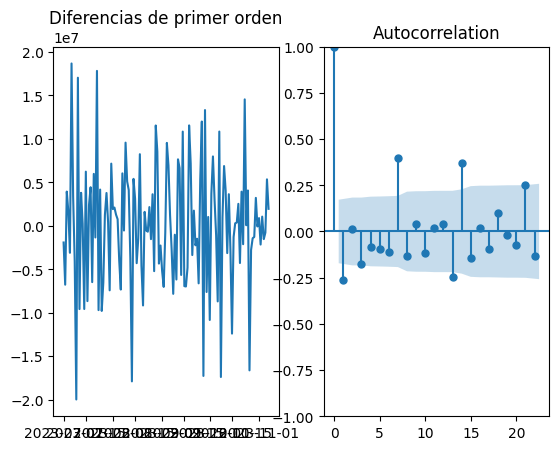

In [ ]:
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('Diferencias de primer orden')
ax1.plot(fsue.diff())

ax2 = f.add_subplot(122)
plot_acf(fsue.diff().dropna(), ax=ax2)

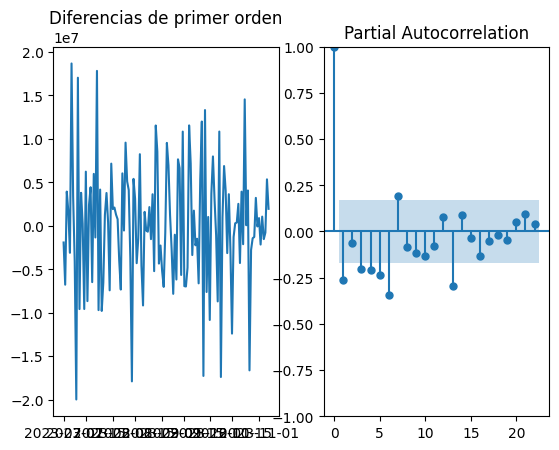

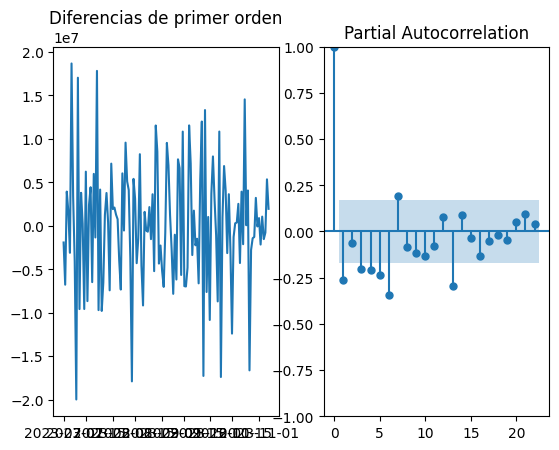

In [ ]:
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('Diferencias de primer orden')
ax1.plot(fsue.diff())

ax2 = f.add_subplot(122)
plot_pacf(fsue.diff().dropna(), ax=ax2)

* El autocorrelograma parcial nos indica que el modelo ARIMA debería tener 1 o 2 autorregresivos

# 2. Estimación

## 2.1 ARIMA (ordinario)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                  monto   No. Observations:                  131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2230.350
Date:                Sat, 06 Jan 2024   AIC                           4466.701
Time:                        03:31:16   BIC                           4475.304
Sample:                    06-30-2023   HQIC                          4470.197
                         - 11-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2734      0.087     -3.129      0.002      -0.445      -0.102
ar.L2         -0.0838      0.104     -0.804      0.421      -0.288       0.121
sigma2      4.707e+13        nan        nan        n

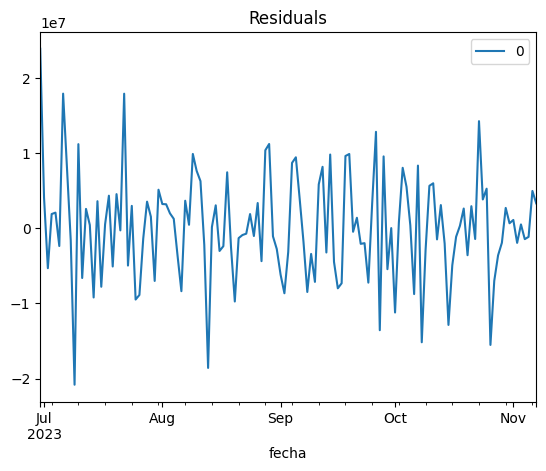

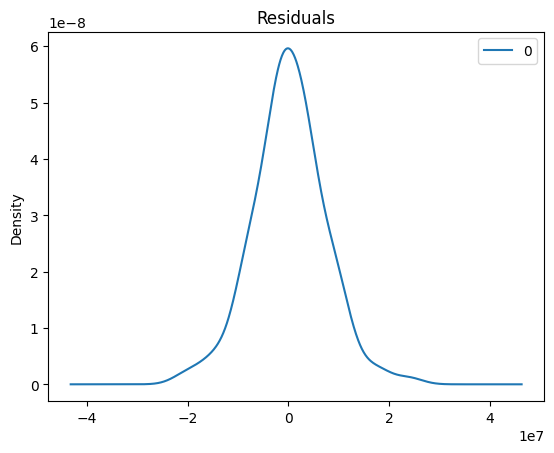

                  0
count  1.310000e+02
mean   1.700943e+05
std    7.147909e+06
min   -2.082065e+07
25%   -3.582688e+06
50%    1.824040e+05
75%    3.901738e+06
max    2.392743e+07


In [ ]:
# Ajuste del modelo (fit)
model = ARIMA(fsue, order=(2,1,0))
model_fit = model.fit()

# Resumen estadístico
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot(title='Residuals')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title='Residuals')
plt.show()

# summary stats of residuals
print(residuals.describe())

## 2.2 SARIMAX

In [ ]:
## The Triunvirate
sarimax = sm.tsa.statespace.SARIMAX(endog=fsue,order=(1,1,1),seasonal_order=(0,0,0,7),enforce_invertibility=False)

sarimax_fit = sarimax.fit()

print(sarimax_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                  monto   No. Observations:                  131
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2222.251
Date:                Sat, 06 Jan 2024   AIC                           4450.503
Time:                        03:31:18   BIC                           4459.105
Sample:                    06-30-2023   HQIC                          4453.998
                         - 11-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4888      0.118      4.157      0.000       0.258       0.719
ma.L1         -0.9254      0.064    -14.363      0.000      -1.052      -0.799
sigma2      4.738e+13        nan        nan        n

# 3. Diagnóstico

In [ ]:
# Modelo con normalidad (Jarque Bera), sin correlación serial (Prueba Ljung Box) y con errores homoscedásticos
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  monto   No. Observations:                  131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2230.350
Date:                Sat, 06 Jan 2024   AIC                           4466.701
Time:                        03:31:18   BIC                           4475.304
Sample:                    06-30-2023   HQIC                          4470.197
                         - 11-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2734      0.087     -3.129      0.002      -0.445      -0.102
ar.L2         -0.0838      0.104     -0.804      0.421      -0.288       0.121
sigma2      4.707e+13        nan        nan        n

In [ ]:
# Modelo SARIMA
print(sarimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  monto   No. Observations:                  131
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2222.251
Date:                Sat, 06 Jan 2024   AIC                           4450.503
Time:                        03:31:18   BIC                           4459.105
Sample:                    06-30-2023   HQIC                          4453.998
                         - 11-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4888      0.118      4.157      0.000       0.258       0.719
ma.L1         -0.9254      0.064    -14.363      0.000      -1.052      -0.799
sigma2      4.738e+13        nan        nan        n

# 4. Proyección

In [ ]:
# 2023-06-30 - 2023-11-07


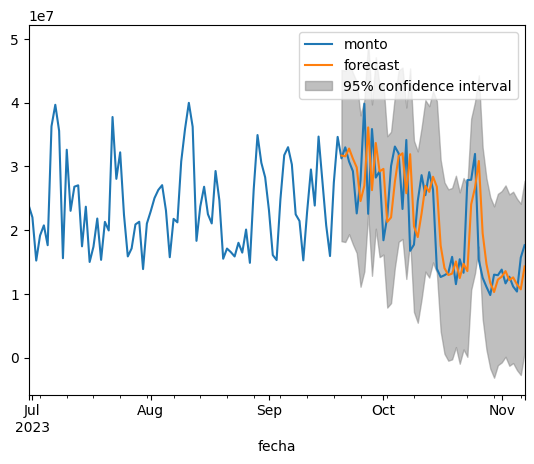

In [ ]:
fig, ax = plt.subplots()

ax = df['monto'].plot(ax=ax)
plot_predict(model_fit, '2023-09-20', '2023-11-07', ax= ax)
plt.show()

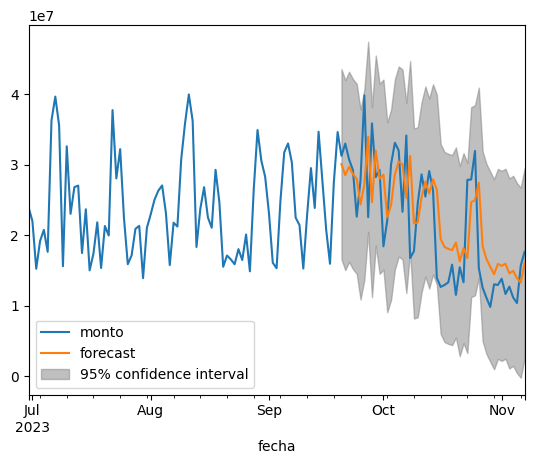

In [ ]:
fig, ax = plt.subplots()

ax = df['monto'].plot(ax=ax)
plot_predict(sarimax_fit, '2023-09-20', '2023-11-07', ax= ax)
plt.show()

## 4.1 Evaluando las proyecciones

* Proyecciones son adecuadas

In [ ]:
def train_test_split_ori(X):
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    return X_train, X_test

def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

* Mediante ciclo se calcula la y estimada para compararla con los datos de pruebas
* Se junta la información en listas para poder ocupar las funciones de mean_squared_error() y mape()

## 4.1.1 ARIMA Model

[31995993.77182782]
[25903727.67840641]
[31946233.05952812]
[21219826.58115281]
[19258613.8694102]
[22281645.49353165]
[26558093.22396647]
[25963802.51106223]
[28346893.84886353]
[26777485.95043935]
[18101749.76657981]
[14485700.39924531]
[12983468.45544198]
[13146087.87418365]
[15021560.00212763]
[12493067.82025161]
[14757508.95009271]
[13494133.67332367]
[23697223.79752187]
[26360714.88035621]
[30782488.11814994]
[19878597.58263425]
[14871111.02869346]
[11724252.30043538]
[10277380.47711734]
[12233900.31819728]
[12678574.29482765]
[13566201.44361756]
[12158323.35111739]
[12574379.82449817]
[11481236.76775589]
[10697568.40440501]
[14281564.8967279]
Test RMSE: 6314883.303
Test MAPE: 0.270


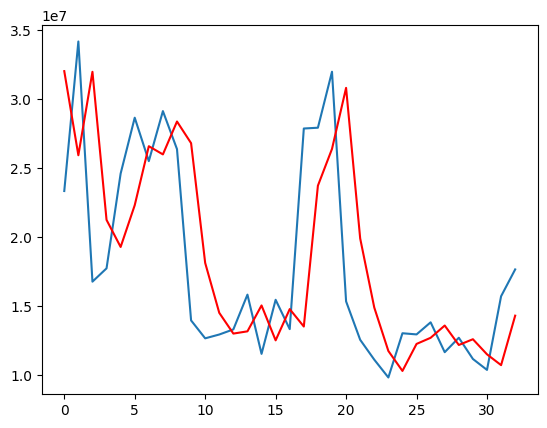

In [ ]:
# split into train and test sets
Y = fsue.values
size = int(len(Y) * 0.75)

y_train, y_test = Y[:size], Y[size:len(Y)]   #Separa datos de entrenamiento y datos de pruebas
history = [x for x in y_train]
predictions = list()

# Validación walk-forward
for t in range(len(y_test)):

    model = ARIMA(history, order=(2,1,0))  #(2,1,0) la mejor combinación  #(3,1,0) buena combinación
    model_fit = model.fit()
    output = model_fit.forecast()

    #print('----------------Output----------------')
    print(output)
    #print('--------------------------------------')

    yhat = output[0]
    predictions.append(yhat)
    obs = y_test[t]
    history.append(obs)    #Junta datos de entrenamiento y pruebas

    #print('predicted=%f, expected=%f' % (yhat, obs))


# Resultados de RMSE y MAPE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

mape_score = mape(y_test, predictions)
print('Test MAPE: %.3f' % mape_score)

# Gráfica de datos estimados vs datos de pruebas
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()

## 4.1.2 SARIMAX Model

2023-11-08    1.710075e+07
2023-11-09    1.684108e+07
2023-11-10    1.671416e+07
2023-11-11    1.665213e+07
Freq: D, Name: predictions_statsmodels, dtype: float64

Test RMSE: 7159861.306
Test MAPE: 0.308


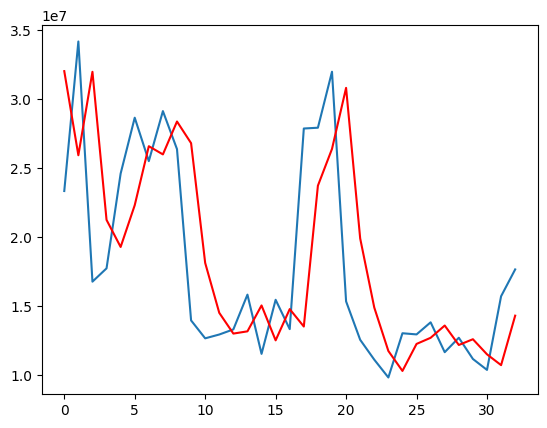

In [ ]:
predictions_sarima = sarimax_fit.get_forecast(steps=len(y_test)).predicted_mean
predictions_sarima.name = 'predictions_statsmodels'
display(predictions_sarima.head(4))

# # split into train and test sets
# Y = fsue.values
# size = int(len(Y) * 0.75)

# y_train, y_test = Y[:size], Y[size:len(X)]   #Separa datos de entrenamiento y datos de pruebas
# history = [x for x in train]
# predictions = list()

# # Validación walk-forward
# for t in range(len(test)):

#     model = sm.tsa.statespace.SARIMAX(endog=fsue,order=(2,1,0), seasonal_order=(0,0,1,7), trend='c', enforce_invertibility=False)  #(2,1,0) la mejor combinación  #(3,1,0) buena combinación
#     model_fit = model.fit()
#     output = model_fit.forecast()

#     #print('----------------Output----------------')
#     print(output)
#     #print('--------------------------------------')

#     yhat = output[0]
#     predictions.append(yhat)
#     obs = y_test[t]
#     history.append(obs)    #Junta datos de entrenamiento y pruebas

#     #print('predicted=%f, expected=%f' % (yhat, obs))


# Resultados de RMSE y MAPE
rmse = np.sqrt(mean_squared_error(y_test, predictions_sarima))
print('Test RMSE: %.3f' % rmse)

mape_score = mape(y_test, predictions_sarima)
print('Test MAPE: %.3f' % mape_score)

# Gráfica de datos estimados vs datos de pruebas
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.show()

# 5. Proyecciones a largo plazo

* Se añaden obs adicionales al dataframe y al indice del dataframe
* Se cinca

In [ ]:
print(df.index[-1])

future_dates = [df.index[-1] + DateOffset(days = x) for x in range(0, 200)]
future_dates

df_future_arima = pd.DataFrame(index=future_dates[1:], columns = df.columns)

df_future_arima.head()


2023-11-07 00:00:00


,fecha,monto
2023-11-08,NaN,NaN
2023-11-09,NaN,NaN
2023-11-10,NaN,NaN
2023-11-11,NaN,NaN
2023-11-12,NaN,NaN


In [ ]:
print(df.index[-1])

future_dates = [df.index[-1] + DateOffset(days = x) for x in range(0, 200)]
future_dates

df_future_sarima = pd.DataFrame(index=future_dates[1:], columns = df.columns)

df_future_sarima.head()

2023-11-07 00:00:00


,fecha,monto
2023-11-08,NaN,NaN
2023-11-09,NaN,NaN
2023-11-10,NaN,NaN
2023-11-11,NaN,NaN
2023-11-12,NaN,NaN


In [ ]:
model = ARIMA(fsue, order=(2,1,0))  #(2,1,0) la mejor combinación  #(3,1,0) buena combinación
model_fit = model.fit()

print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:                  monto   No. Observations:                  131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2230.350
Date:                Sat, 06 Jan 2024   AIC                           4466.701
Time:                        03:31:27   BIC                           4475.304
Sample:                    06-30-2023   HQIC                          4470.197
                         - 11-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2734      0.087     -3.129      0.002      -0.445      -0.102
ar.L2         -0.0838      0.104     -0.804      0.421      -0.288       0.121
sigma2      4.707e+13        nan        nan        n

In [ ]:
forecasts = model_fit.predict(start = 133, end = 331, dynamic=True)

print(forecasts)
print(type(forecasts))

df_future_arima['monto'] = forecasts.values
df_future_arima


2023-11-10    1.681121e+07
2023-11-11    1.678783e+07
2023-11-12    1.678974e+07
2023-11-13    1.679118e+07
2023-11-14    1.679062e+07
                  ...     
2024-05-22    1.679068e+07
2024-05-23    1.679068e+07
2024-05-24    1.679068e+07
2024-05-25    1.679068e+07
2024-05-26    1.679068e+07
Freq: D, Name: predicted_mean, Length: 199, dtype: float64
<class 'pandas.core.series.Series'>


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:2473: ValueWarning:

Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.



,fecha,monto
2023-11-08,NaN,1.681121e+07
2023-11-09,NaN,1.678783e+07
2023-11-10,NaN,1.678974e+07
2023-11-11,NaN,1.679118e+07
2023-11-12,NaN,1.679062e+07
...,...,...
2024-05-20,NaN,1.679068e+07
2024-05-21,NaN,1.679068e+07
2024-05-22,NaN,1.679068e+07
2024-05-23,NaN,1.679068e+07


In [ ]:
predictions_sarima = sarimax_fit.get_forecast(steps=199).predicted_mean
predictions_sarima.name = 'Predicciones SARIMA'
predictions_sarima.head()


df_future_sarima['monto'] = predictions_sarima.values
df_future_sarima

,fecha,monto
2023-11-08,NaN,1.710075e+07
2023-11-09,NaN,1.684108e+07
2023-11-10,NaN,1.671416e+07
2023-11-11,NaN,1.665213e+07
2023-11-12,NaN,1.662181e+07
...,...,...
2024-05-20,NaN,1.659282e+07
2024-05-21,NaN,1.659282e+07
2024-05-22,NaN,1.659282e+07
2024-05-23,NaN,1.659282e+07


In [ ]:
preds, conf_int = pipe.predict(n_periods=199, return_conf_int=True)
print("\nForecasts:")
print(preds)


df_future_sarima['monto'] = preds.values
df_future_sarima


Forecasts:
100    2.738503e+07
101    1.807495e+07
102    1.695469e+07
103    1.784345e+07
104    1.784762e+07
           ...     
294    2.044201e+07
295    2.585513e+07
296    3.159888e+07
297    2.527494e+07
298    2.427394e+07
Length: 199, dtype: float64


,fecha,monto
2023-11-08,NaN,2.738503e+07
2023-11-09,NaN,1.807495e+07
2023-11-10,NaN,1.695469e+07
2023-11-11,NaN,1.784345e+07
2023-11-12,NaN,1.784762e+07
...,...,...
2024-05-20,NaN,2.044201e+07
2024-05-21,NaN,2.585513e+07
2024-05-22,NaN,3.159888e+07
2024-05-23,NaN,2.527494e+07


In [ ]:
df_arima = pd.concat([df, df_future_arima])
df_arima = df_arima[['monto']]

print(len(df_arima))
print(df_arima.shape)
print(df_arima.info())

df_arima


df_sarima = pd.concat([df, df_future_sarima])
df_sarima = df_sarima[['monto']]

print(len(df_sarima))
print(df_sarima.shape)
print(df_sarima.info())

df_sarima

330
(330, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2023-06-30 to 2024-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   monto   330 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
None
330
(330, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2023-06-30 to 2024-05-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   monto   330 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
None


,monto
2023-06-30,2.392743e+07
2023-07-01,2.199993e+07
2023-07-02,1.521925e+07
2023-07-03,1.914576e+07
2023-07-04,2.074083e+07
...,...
2024-05-20,2.044201e+07
2024-05-21,2.585513e+07
2024-05-22,3.159888e+07
2024-05-23,2.527494e+07


<Axes: >

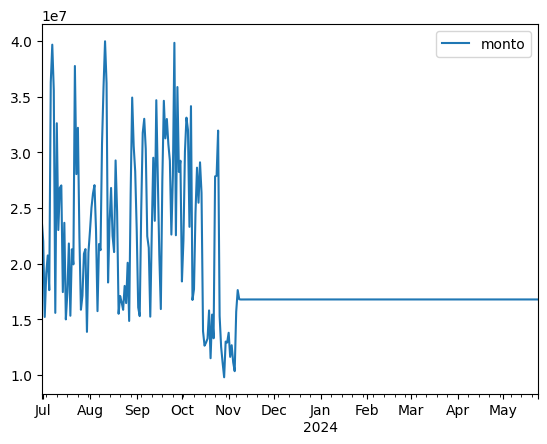

In [ ]:
df_arima.plot()

<Axes: >

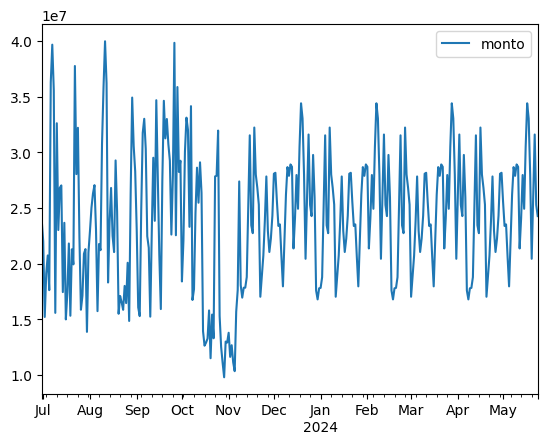

In [ ]:
df_sarima.plot()

In [ ]:
# df_arima.to_excel('/content/drive/MyDrive/Colab_Notebooks/Cenace/DatasetsCENACE/proyFSUE_ARIMA.xlsx')
df_sarima.to_excel('/content/drive/MyDrive/Colab_Notebooks/Cenace/DatasetsCENACE/proyFSUE_SARIMA.xlsx')

# Adicional Funciones

In [ ]:
# split into train and test sets



# history = [x for x in train]
# predictions = list()

# # walk-forward validation
# for t in range(len(test)):
#  model = ARIMA(history, order=(5,1,0))
#  model_fit = model.fit()
#  output = model_fit.forecast()



# yhat = output[0]
#  predictions.append(yhat)
#  obs = test[t]
#  history.append(obs)
#  print('predicted=%f, expected=%f' % (yhat, obs))

# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)

# # plot forecasts against actual outcomes
# pyplot.plot(test)
# pyplot.plot(predictions, color='red')
# pyplot.show()